In [ ]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import csv
import subprocess
import random
import pandas as pd
from PIL import Image
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

In [2]:
# Paths
base_path = '/kaggle/input/kinetics400/kinetics400'
resized_videos_path = os.path.join(base_path, '/kaggle/input/kinetics400/kinetics400/resized_videos')
processed_frames_path = os.path.join(base_path, '/kaggle/input/kinetics400/kinetics400/processed_frames')
train_csv = os.path.join(base_path, '/kaggle/input/kinetics400/kinetics400/train_annotations.csv')
val_csv = os.path.join(base_path, '/kaggle/input/kinetics400/kinetics400/val_annotations.csv')

In [3]:
def create_train_val_annotations(frames_folder, train_csv, val_csv, val_split=0.2):
    # Get all label folders
    label_folders = [os.path.join(frames_folder, label) for label in os.listdir(frames_folder)]
    all_annotations = []

    for label_folder in label_folders:
        if os.path.isdir(label_folder):
            label = os.path.basename(label_folder)
            frame_files = [os.path.join(label_folder, file) for file in os.listdir(label_folder)]
            all_annotations.extend([(frame_file, label) for frame_file in frame_files])

    # Shuffle and split annotations into train/val
    random.shuffle(all_annotations)
    split_idx = int(len(all_annotations) * (1 - val_split))
    train_annotations = all_annotations[:split_idx]
    val_annotations = all_annotations[split_idx:]

    print(f"Training annotations: {len(train_annotations)}")
    print(f"Validation annotations: {len(val_annotations)}")

    # Write training annotations to CSV
    train_csv_path = os.path.join('/kaggle/working', train_csv)
    with open(train_csv_path, 'w', newline='') as train_file:
        writer = csv.writer(train_file)
        writer.writerow(['frame_folder', 'label'])  # Write header
        writer.writerows(train_annotations)

    # Write validation annotations to CSV
    val_csv_path = os.path.join('/kaggle/working', val_csv)
    with open(val_csv_path, 'w', newline='') as val_file:
        writer = csv.writer(val_file)
        writer.writerow(['frame_folder', 'label'])  # Write header
        writer.writerows(val_annotations)

    print(f"Train annotations saved to: {train_csv_path}")
    print(f"Validation annotations saved to: {val_csv_path}")

In [4]:
# Call the function
create_train_val_annotations(
    frames_folder=processed_frames_path,
    train_csv='train_annotations.csv',
    val_csv='val_annotations.csv'
)

Training annotations: 6653
Validation annotations: 1664
Train annotations saved to: /kaggle/working/train_annotations.csv
Validation annotations saved to: /kaggle/working/val_annotations.csv


In [5]:
# Reading the CSV files
train_annotations = pd.read_csv('/kaggle/working/train_annotations.csv')
val_annotations = pd.read_csv('/kaggle/working/val_annotations.csv')

# Displaying the head of the annotations
print("Train Annotations:")
print(train_annotations.head())

print("Validation Annotations:")
print(val_annotations.head())

Train Annotations:
                                        frame_folder           label
0  /kaggle/input/kinetics400/kinetics400/processe...       abseiling
1  /kaggle/input/kinetics400/kinetics400/processe...         archery
2  /kaggle/input/kinetics400/kinetics400/processe...  applying cream
3  /kaggle/input/kinetics400/kinetics400/processe...       abseiling
4  /kaggle/input/kinetics400/kinetics400/processe...    air drumming
Validation Annotations:
                                        frame_folder           label
0  /kaggle/input/kinetics400/kinetics400/processe...       abseiling
1  /kaggle/input/kinetics400/kinetics400/processe...  applying cream
2  /kaggle/input/kinetics400/kinetics400/processe...    air drumming
3  /kaggle/input/kinetics400/kinetics400/processe...       abseiling
4  /kaggle/input/kinetics400/kinetics400/processe...  applying cream


In [6]:
from PIL import Image
import os
import pandas as pd
import torch
from torch.utils.data import Dataset

class FrameDataset(Dataset):
    def __init__(self, annotations_file, transform=None, num_frames=16, label_to_index=None, base_dir=None):
        """
        Dataset for loading video frames.

        Parameters:
        - annotations_file: Path to the CSV file with frame paths and labels.
        - transform: Transformations to apply to each frame.
        - num_frames: Number of frames per sequence.
        - label_to_index: Mapping of label names to indices.
        - base_dir: Base directory for frame paths (optional).
        """
        self.annotations = pd.read_csv(annotations_file)
        self.transform = transform
        self.num_frames = num_frames
        self.label_to_index = label_to_index
        self.base_dir = base_dir  # Base directory for resolving frame paths

    def __len__(self):
        return len(self.annotations) // self.num_frames  # Each sample is a sequence of frames

    def __getitem__(self, idx):
        # Get the starting index for the sequence
        start_idx = idx * self.num_frames
        sequence_frames = self.annotations.iloc[start_idx:start_idx + self.num_frames]

        frames = []

        for frame_file in sequence_frames['frame_folder']:
            # Resolve full path for the frame
            frame_path = frame_file
            if self.base_dir and not os.path.isabs(frame_file):
                frame_path = os.path.join(self.base_dir, frame_file)

            if not os.path.exists(frame_path):
                raise FileNotFoundError(f"Frame not found: {frame_path}")

            frame = Image.open(frame_path).convert("RGB")
            if self.transform:
                frame = self.transform(frame)
            frames.append(frame)

        # Handle cases with fewer frames than num_frames
        if len(frames) < self.num_frames:
            pad_frames = [torch.zeros_like(frames[0])] * (self.num_frames - len(frames))
            frames.extend(pad_frames)

        # Handle cases with more frames than num_frames
        if len(frames) > self.num_frames:
            frames = frames[:self.num_frames]

        # Stack frames into a single tensor
        frames_tensor = torch.stack(frames, dim=0)

        # Retrieve the label
        label = sequence_frames.iloc[0]['label']
        if self.label_to_index:
            label = self.label_to_index[label]

        return frames_tensor, torch.tensor(label, dtype=torch.long)


In [7]:
# Create a mapping from label names to indices
label_to_index = {label: idx for idx, label in enumerate(sorted(os.listdir(processed_frames_path)))}
print(f"Label to Index Mapping: {label_to_index}")


Label to Index Mapping: {'abseiling': 0, 'air drumming': 1, 'answering questions': 2, 'applauding': 3, 'applying cream': 4, 'archery': 5}


In [18]:
# Define transformation to match model requirements
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Match model's image size
    transforms.ToTensor(),          # Convert to tensor
])

# Use the correct base directory for the dataset
train_dataset = FrameDataset(
    annotations_file='/kaggle/working/train_annotations.csv',
    transform=transform,
    num_frames=16,
    label_to_index=label_to_index,
    base_dir=processed_frames_path  # Correct base directory
)

val_dataset = FrameDataset(
    annotations_file='/kaggle/working/val_annotations.csv',
    transform=transform,
    num_frames=16,
    label_to_index=label_to_index,
    base_dir=processed_frames_path  # Correct base directory
)


#short
# train_dataset = torch.utils.data.Subset(train_dataset, range(50))  # Use the first 50 samples
# val_dataset = torch.utils.data.Subset(val_dataset, range(20))  # Use the first 20 samples

# Print the lengths of your datasets to check for emptiness
print(f"Train Dataset Length: {len(train_dataset)}")
print(f"Validation Dataset Length: {len(val_dataset)}")

# Create DataLoaders

train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=True, num_workers=0)
val_dataloader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)



Train Dataset Length: 415
Validation Dataset Length: 104


In [19]:
for videos, labels in train_dataloader:
    print("Video batch shape:", videos.shape)
    break

Video batch shape: torch.Size([1, 16, 3, 224, 224])


In [20]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import VideoMAEForVideoClassification

In [30]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from transformers import VideoMAEForVideoClassification

class RViT(nn.Module):
    def __init__(self, num_classes, hidden_dim, num_layers, frame_dim):
        super().__init__()
        self.trunk = VideoMAEForVideoClassification.from_pretrained("MCG-NJU/videomae-huge-finetuned-kinetics")
        self.hidden_dim = hidden_dim
        self.feature_projector = nn.Linear(400, hidden_dim)
        self.rvit_units = nn.ModuleList([RViTUnit(hidden_dim) for _ in range(num_layers)])
        self.classifier = nn.Linear(hidden_dim, num_classes)
        self.frame_reconstruction = nn.Sequential(
            nn.Conv3d(hidden_dim, 64, kernel_size=(1, 3, 3), padding=(0, 1, 1)),
            nn.ReLU(),
            nn.Conv3d(64, frame_dim[0], kernel_size=(1, 3, 3), padding=(0, 1, 1))
        )
        self.temporal_upsample = nn.Upsample(size=(15, 224, 224), mode='trilinear', align_corners=False)

    def forward(self, x):
        # print("Input shape:", x.shape)
    
        # Add batch dimension if it's missing
        if x.dim() == 5:
            pass  # Input is already in the correct shape
        elif x.dim() == 4:
            x = x.unsqueeze(0)  # Add batch dimension
        else:
            raise ValueError(f"Expected input x to have 4 or 5 dimensions, but got {x.dim()}")

        
        # print("Modified input shape:", x.shape)
        
        # Pass through trunk (VideoMAE backbone)
        # trunk_output = self.trunk(x)
        trunk_output = self.trunk(pixel_values=x)

        # print("Trunk output logits shape:", trunk_output.logits.shape)
    
        # Project features
        features = self.feature_projector(trunk_output.logits)
        # print("Projected features shape:", features.shape)
    
        # Recurrent processing
        h = torch.zeros(features.size(0), 1, self.hidden_dim, device=features.device)
        for idx, unit in enumerate(self.rvit_units):
            h = unit(features, h)
            # print(f"Recurrent unit {idx} output shape:", h.shape)

        # Use the last time step for classification
        h_last = h[:, -1, :]
    
        # Classifier output
        action_logits = self.classifier(h_last)
        # print("Action logits shape:", action_logits.shape)
    
        # Frame reconstruction
        h_last = h_last.unsqueeze(-1).unsqueeze(-1).unsqueeze(-1)  # Shape: (batch_size, hidden_dim, 1, 1, 1)
        # print("Recurrent hidden state shape (unsqueezed):", h_last.shape)
        predicted_frame = self.frame_reconstruction(h_last)
        # print("Predicted frame shape before upsample:", predicted_frame.shape)
        predicted_frame = self.temporal_upsample(predicted_frame)
        # print("Predicted frame shape after upsample:", predicted_frame.shape)
    
        return action_logits, predicted_frame
class AttentionGate(nn.Module):
    def __init__(self, hidden_dim):
        super().__init__()
        self.Wq = nn.Linear(hidden_dim, hidden_dim)
        self.Wk = nn.Linear(hidden_dim, hidden_dim)
        self.Wv = nn.Linear(hidden_dim, hidden_dim)
    
    def forward(self, x, h):
        # Ensure x and h have the same number of dimensions
        if x.dim() != h.dim():
            x = x.unsqueeze(1)
        
        q = F.elu(self.Wq(x) + self.Wq(h))
        k = F.elu(self.Wk(x) + self.Wk(h))
        v = self.Wv(x) + self.Wv(h)
        
        # Reshape for batch matrix multiplication
        batch_size, seq_len, hidden_dim = q.size()
        q = q.view(-1, 1, hidden_dim)  # Shape: (batch_size * seq_len, 1, hidden_dim)
        k = k.view(-1, hidden_dim, 1)  # Shape: (batch_size * seq_len, hidden_dim, 1)
        v = v.view(batch_size, seq_len, hidden_dim)  # Keep v as (batch_size, seq_len, hidden_dim)
        
        # Compute attention scores
        attn = torch.bmm(q, k).squeeze(2)  # Shape: (batch_size * seq_len, 1)
        attn = attn.view(batch_size, seq_len, 1)  # Reshape back to (batch_size, seq_len, 1)
        
        # Element-wise multiplication
        output = attn * v  # Shape: (batch_size, seq_len, hidden_dim)
        return output

class RecurrentDropout(nn.Module):
    def __init__(self, dropout_rate):
        super().__init__()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        return self.dropout(x)

class RViTUnit(nn.Module):
    def __init__(self, hidden_dim, dropout_rate=0.1):
        super().__init__()
        self.attention_gate = AttentionGate(hidden_dim)
        self.layer_norm1 = nn.LayerNorm(hidden_dim)
        self.layer_norm2 = nn.LayerNorm(hidden_dim)
        self.ffn = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim * 4),
            nn.GELU(),
            nn.Linear(hidden_dim * 4, hidden_dim)
        )
        self.recurrent_dropout = RecurrentDropout(dropout_rate)
    
    def forward(self, x, h):
        # Ensure x and h have the same number of dimensions
        if x.dim() != h.dim():
            x = x.unsqueeze(1)
        
        # Attention mechanism
        attn_output = self.attention_gate(x, h)
        
        # Apply dropout
        attn_output = self.recurrent_dropout(attn_output)
        
        # Residual connection and layer normalization
        h_new = self.layer_norm1(h + attn_output)
        h_new = self.layer_norm2(h_new + self.ffn(h_new))
        return h_new



In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = RViT(num_classes=len(label_to_index), hidden_dim=512, num_layers=4, frame_dim=(3, 224, 224)).to(device)

In [13]:
!pip install torchsummary

In [14]:
from torchvision import models
from torchsummary import summary

In [32]:
# Include batch size in input_size
summary(model, input_size=(16, 3, 224, 224), device='cuda')

Layer (type:depth-idx)                                                 Output Shape              Param #
RViT                                                                   [1, 6]                    --
├─VideoMAEForVideoClassification: 1-1                                  [1, 400]                  --
│    └─VideoMAEModel: 2-1                                              [1, 1568, 1280]           --
│    │    └─VideoMAEEmbeddings: 3-1                                    [1, 1568, 1280]           1,967,360
│    │    └─VideoMAEEncoder: 3-2                                       [1, 1568, 1280]           629,637,120
│    └─LayerNorm: 2-2                                                  [1, 1280]                 2,560
│    └─Linear: 2-3                                                     [1, 400]                  512,400
├─Linear: 1-2                                                          [1, 512]                  205,312
├─ModuleList: 1-3                                                 

In [ ]:
# After training your model
torch.save(model.state_dict(), 'rvit_model_weights.pth')


Recall the model 

In [ ]:
# Re-import necessary modules and define the classes
import torch
import torch.nn as nn
from transformers import VideoMAEForVideoClassification

# Define your model classes here (RViT, RViTUnit, etc.)

# Create an instance of your model
model = RViT(num_classes=len(label_to_index), hidden_dim=512, num_layers=4, frame_dim=(3, 224, 224))
model.load_state_dict(torch.load('rvit_model_weights.pth'))
model.to(device)


In [33]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from transformers import VideoMAEForVideoClassification
import gc

In [25]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [ ]:
num_epochs = 10  # Set the number of epochs
accumulation_steps = 4  # Adjust based on your memory constraints

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    optimizer.zero_grad()
    
    # Loop over batches
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        action_logits, predicted_frame = outputs

        # Compute loss
        loss = criterion(action_logits, labels) / accumulation_steps  # Normalize loss

        # Backward pass
        loss.backward()

        # Update running loss (multiply by accumulation_steps to get the original loss value)
        running_loss += loss.item() * accumulation_steps * inputs.size(0)  # Multiply by batch size
        _, preds = torch.max(action_logits, 1)
        running_corrects += torch.sum(preds == labels.data)

        # Gradient accumulation step
        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_dataloader):
            optimizer.step()
            optimizer.zero_grad()
    
    # Compute epoch loss and accuracy
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    print(f'Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.4f}')

    # Clear GPU cache
    torch.cuda.empty_cache()
    gc.collect()

    # Optional: Add validation loop here
    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            action_logits, predicted_frame = outputs
            loss = criterion(action_logits, labels)

            val_running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(action_logits, 1)
            val_running_corrects += torch.sum(preds == labels.data)

    val_epoch_loss = val_running_loss / len(val_dataset)
    val_epoch_acc = val_running_corrects.double() / len(val_dataset)

    print(f'Validation Loss: {val_epoch_loss:.4f} - Validation Acc: {val_epoch_acc:.4f}')



* Validation Loss: 2.2521 - Validation Acc: 0.1000
* Validation Loss: 2.3495 - Validation Acc: 0.1000
* Validation Loss: 1.9162 - Validation Acc: 0.3000
* Validation Loss: 2.0011 - Validation Acc: 0.3000
* Validation Loss: 1.8997 - Validation Acc: 0.3000
* Validation Loss: 1.9295 - Validation Acc: 0.3000
* Validation Loss: 1.9627 - Validation Acc: 0.3000
* Validation Loss: 2.0479 - Validation Acc: 0.1000
* Validation Loss: 1.9307 - Validation Acc: 0.3000

Train/test/validation

In [34]:
num_epochs = 10  # Set the number of epochs
accumulation_steps = 4  # Adjust based on your memory constraints

# Initialize lists to store loss and accuracy
train_losses = []
train_accuracies = []
val_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    running_corrects = 0
    optimizer.zero_grad()
    
    # Loop over batches
    for i, (inputs, labels) in enumerate(train_dataloader):
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(inputs)
        action_logits, predicted_frame = outputs

        # Compute loss
        loss = criterion(action_logits, labels) / accumulation_steps  # Normalize loss

        # Backward pass
        loss.backward()

        # Update running loss (multiply by accumulation_steps to get the original loss value)
        running_loss += loss.item() * accumulation_steps * inputs.size(0)  # Multiply by batch size
        _, preds = torch.max(action_logits, 1)
        running_corrects += torch.sum(preds == labels.data)

        # Gradient accumulation step
        if (i + 1) % accumulation_steps == 0 or (i + 1) == len(train_dataloader):
            optimizer.step()
            optimizer.zero_grad()
    
    # Compute epoch loss and accuracy
    epoch_loss = running_loss / len(train_dataset)
    epoch_acc = running_corrects.double() / len(train_dataset)

    # Append to lists
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_acc.item())

    print(f'Epoch [{epoch+1}/{num_epochs}] - Loss: {epoch_loss:.4f} - Acc: {epoch_acc:.4f}')

    # Clear GPU cache
    torch.cuda.empty_cache()
    gc.collect()

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    val_running_corrects = 0

    with torch.no_grad():
        for inputs, labels in val_dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            action_logits, predicted_frame = outputs
            loss = criterion(action_logits, labels)

            val_running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(action_logits, 1)
            val_running_corrects += torch.sum(preds == labels.data)

    val_epoch_loss = val_running_loss / len(val_dataset)
    val_epoch_acc = val_running_corrects.double() / len(val_dataset)

    # Append to lists
    val_losses.append(val_epoch_loss)
    val_accuracies.append(val_epoch_acc.item())

    print(f'Validation Loss: {val_epoch_loss:.4f} - Validation Acc: {val_epoch_acc:.4f}')


Epoch [1/10] - Loss: 1.9696 - Acc: 0.1663
Validation Loss: 1.8682 - Validation Acc: 0.2500
Epoch [2/10] - Loss: 1.9476 - Acc: 0.1566
Validation Loss: 1.8682 - Validation Acc: 0.2500
Epoch [3/10] - Loss: 1.9606 - Acc: 0.1855
Validation Loss: 1.8682 - Validation Acc: 0.2500
Epoch [4/10] - Loss: 1.9397 - Acc: 0.1566
Validation Loss: 1.8682 - Validation Acc: 0.2500
Epoch [5/10] - Loss: 1.9430 - Acc: 0.1735
Validation Loss: 1.8682 - Validation Acc: 0.2500
Epoch [6/10] - Loss: 1.8867 - Acc: 0.1880
Validation Loss: 1.8682 - Validation Acc: 0.2500
Epoch [7/10] - Loss: 1.9835 - Acc: 0.1759
Validation Loss: 1.8682 - Validation Acc: 0.2500
Epoch [8/10] - Loss: 1.9149 - Acc: 0.1807
Validation Loss: 1.8682 - Validation Acc: 0.2500
Epoch [9/10] - Loss: 1.9170 - Acc: 0.2120
Validation Loss: 1.8682 - Validation Acc: 0.2500
Epoch [10/10] - Loss: 1.9148 - Acc: 0.1904
Validation Loss: 1.8682 - Validation Acc: 0.2500


In [36]:
from matplotlib import pyplot as plt


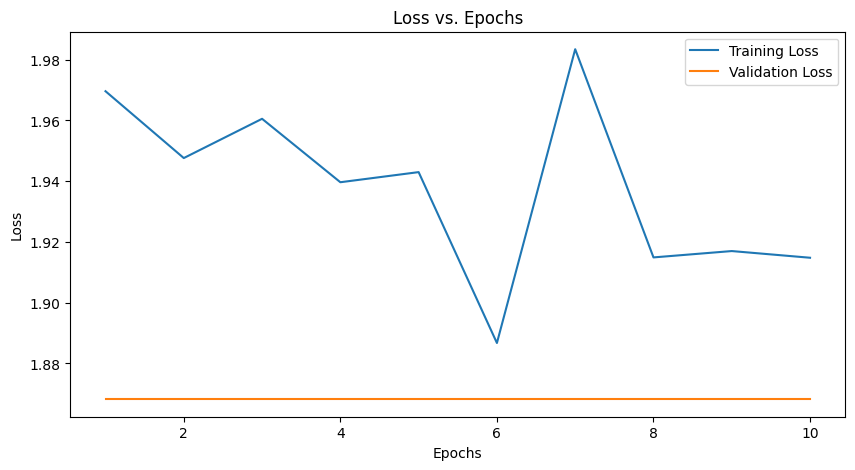

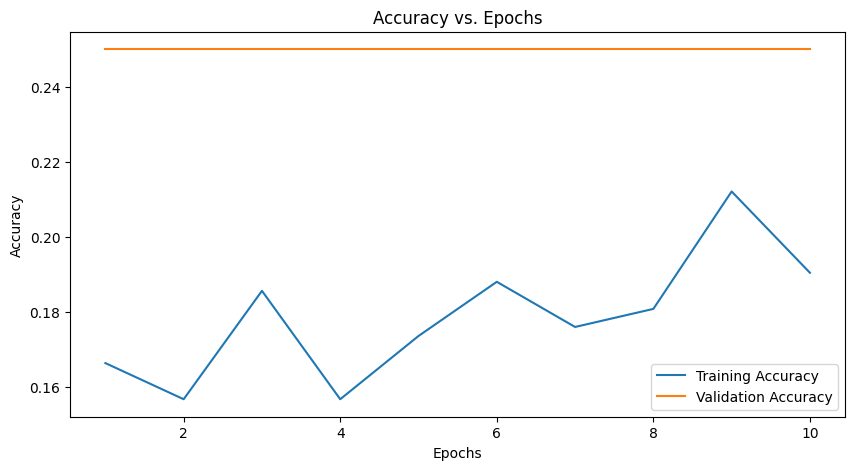

In [37]:
# Plot the training and validation loss
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs + 1), val_losses, label='Validation Loss')
plt.title('Loss vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.title('Accuracy vs. Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


In [ ]:
import torch.nn as nn

# Classification loss
classification_loss_fn = nn.CrossEntropyLoss()

# Reconstruction loss
reconstruction_loss_fn = nn.MSELoss()


In [ ]:
import torch.optim as optim

# Set up the optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# (Optional) Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.1)


In [ ]:
# If possible, reduce num_frames from 16 to 8
frames = frames[:, :8, :, :, :]  # Use only the first 8 frames


In [ ]:
# scaler = torch.cuda.amp.GradScaler()

# for epoch in range(num_epochs):
#     model.train()
#     for batch_idx, (frames, labels) in enumerate(train_dataloader):
#         frames = frames.to(device)
#         labels = labels.to(device)
#         optimizer.zero_grad()
        
#         with torch.cuda.amp.autocast():
#             action_logits, predicted_frame = model(frames)
#             classification_loss = classification_loss_fn(action_logits, labels)
            
#             target_frame = frames[:, 0]
#             predicted_frame = predicted_frame[:, :, 0]
#             reconstruction_loss = reconstruction_loss_fn(predicted_frame, target_frame)
            
#             total_loss = classification_loss + reconstruction_loss
        
#         scaler.scale(total_loss).backward()
#         scaler.step(optimizer)
#         scaler.update()


In [ ]:
import matplotlib.pyplot as plt

# Initialize lists to store training metrics
train_classification_losses = []
train_reconstruction_losses = []
train_total_losses = []
train_accuracies = []

# If you have a validation set
val_classification_losses = []
val_reconstruction_losses = []
val_total_losses = []
val_accuracies = []


In [ ]:
# num_epochs = 10  # Adjust as needed

# scaler = torch.cuda.amp.GradScaler()

# for epoch in range(num_epochs):
#     model.train()
#     total_classification_loss = 0.0
#     total_reconstruction_loss = 0.0
#     total_correct = 0
#     total_samples = 0
#     total_batches = 0

#     for batch_idx, (frames, labels) in enumerate(train_dataloader):
#         frames = frames.to(device)
#         labels = labels.to(device)
#         optimizer.zero_grad()
        
#         with torch.cuda.amp.autocast():
#             action_logits, predicted_frame = model(frames)
#             classification_loss = classification_loss_fn(action_logits, labels)
            
#             target_frame = frames[:, 0]  # Shape: [batch_size, channels, height, width]
#             predicted_frame = predicted_frame[:, :, 0]  # Adjust if necessary
            
#             reconstruction_loss = reconstruction_loss_fn(predicted_frame, target_frame)
#             total_loss = classification_loss + reconstruction_loss
        
#         scaler.scale(total_loss).backward()
#         scaler.step(optimizer)
#         scaler.update()

#         # Update metrics
#         total_classification_loss += classification_loss.item()
#         total_reconstruction_loss += reconstruction_loss.item()
#         total_batches += 1

#         # Calculate accuracy
#         _, predicted_labels = torch.max(action_logits, 1)
#         total_correct += (predicted_labels == labels).sum().item()
#         total_samples += labels.size(0)

#         if batch_idx % 10 == 0:
#             print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_dataloader)}], "
#                   f"Classification Loss: {classification_loss.item():.4f}, "
#                   f"Reconstruction Loss: {reconstruction_loss.item():.4f}")
    
#     # Adjust learning rate if using a scheduler
#     scheduler.step()

#     # Calculate average losses and accuracy for the epoch
#     avg_classification_loss = total_classification_loss / total_batches
#     avg_reconstruction_loss = total_reconstruction_loss / total_batches
#     avg_total_loss = avg_classification_loss + avg_reconstruction_loss
#     accuracy = (total_correct / total_samples) * 100

#     # Append to lists
#     train_classification_losses.append(avg_classification_loss)
#     train_reconstruction_losses.append(avg_reconstruction_loss)
#     train_total_losses.append(avg_total_loss)
#     train_accuracies.append(accuracy)

#     print(f"Epoch [{epoch+1}/{num_epochs}] Training Summary: "
#           f"Avg Classification Loss: {avg_classification_loss:.4f}, "
#           f"Avg Reconstruction Loss: {avg_reconstruction_loss:.4f}, "
#           f"Avg Total Loss: {avg_total_loss:.4f}, "
#           f"Accuracy: {accuracy:.4f}%")


In [ ]:
import torch

num_epochs = 10  # Adjust the number of epochs as needed

for epoch in range(num_epochs):
    model.train()
    total_classification_loss = 0.0
    total_reconstruction_loss = 0.0
    total_correct = 0
    total_samples = 0

    for batch_idx, (frames, labels) in enumerate(train_dataloader):
        frames = frames.to(device)  # Shape: [batch_size, num_frames, channels, height, width]
        labels = labels.to(device)

        optimizer.zero_grad()

        # Forward pass
        action_logits, predicted_frame = model(frames)

        # Compute classification loss
        classification_loss = classification_loss_fn(action_logits, labels)

        # Compute reconstruction loss
        # Assuming you have target frames for reconstruction (e.g., the next frame)
        # For simplicity, we'll use the first frame as the target
        # Compute reconstruction loss

        # Remove the unnecessary unsqueeze
        target_frame = frames[:, 0]  # Shape: [batch_size, channels, height, width]
        
        # Ensure predicted_frame is correctly shaped
        predicted_frame = predicted_frame[:, :, 0]  # Shape: [batch_size, channels, height, width]
        
        # Now both tensors have shape [batch_size, channels, height, width]
        reconstruction_loss = reconstruction_loss_fn(predicted_frame, target_frame)

        # Total loss
        total_loss = classification_loss + reconstruction_loss

        # Backward pass and optimization
        total_loss.backward()
        optimizer.step()

        # Update metrics
        total_classification_loss += classification_loss.item()
        total_reconstruction_loss += reconstruction_loss.item()

        # Calculate accuracy
        _, predicted_labels = torch.max(action_logits, 1)
        total_correct += (predicted_labels == labels).sum().item()
        total_samples += labels.size(0)

        if batch_idx % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_dataloader)}], "
                  f"Classification Loss: {classification_loss.item():.4f}, "
                  f"Reconstruction Loss: {reconstruction_loss.item():.4f}")

    # Adjust learning rate
    scheduler.step()

    # Calculate average losses and accuracy
    avg_classification_loss = total_classification_loss / len(train_dataloader)
    avg_reconstruction_loss = total_reconstruction_loss / len(train_dataloader)
    accuracy = (total_correct / total_samples) * 100

    print(f"Epoch [{epoch+1}/{num_epochs}] Training Summary: "
          f"Avg Classification Loss: {avg_classification_loss:.4f}, "
          f"Avg Reconstruction Loss: {avg_reconstruction_loss:.4f}, "
          f"Accuracy: {accuracy:.2f}%")

    # Perform validation after each epoch
    # (See validation loop below)


In [ ]:
    # Validation
    model.eval()
    val_classification_loss = 0.0
    val_reconstruction_loss = 0.0
    val_total_correct = 0
    val_total_samples = 0

    with torch.no_grad():
        for frames, labels in val_dataloader:
            frames = frames.to(device)
            labels = labels.to(device)

            # Forward pass
            action_logits, predicted_frame = model(frames)

            # Compute classification loss
            classification_loss = classification_loss_fn(action_logits, labels)

            # Compute reconstruction loss
            target_frame = frames[:, 0]
            target_frame = target_frame.unsqueeze(2)
            predicted_frame = predicted_frame[:, :, 0]
            reconstruction_loss = reconstruction_loss_fn(predicted_frame, target_frame)

            # Update metrics
            val_classification_loss += classification_loss.item()
            val_reconstruction_loss += reconstruction_loss.item()

            # Calculate accuracy
            _, predicted_labels = torch.max(action_logits, 1)
            val_total_correct += (predicted_labels == labels).sum().item()
            val_total_samples += labels.size(0)

    # Calculate average losses and accuracy
    avg_val_classification_loss = val_classification_loss / len(val_dataloader)
    avg_val_reconstruction_loss = val_reconstruction_loss / len(val_dataloader)
    val_accuracy = (val_total_correct / val_total_samples) * 100

    print(f"Epoch [{epoch+1}/{num_epochs}] Validation Summary: "
          f"Avg Classification Loss: {avg_val_classification_loss:.4f}, "
          f"Avg Reconstruction Loss: {avg_val_reconstruction_loss:.4f}, "
          f"Accuracy: {val_accuracy:.2f}%")
